[*********************100%***********************]  1 of 1 completed
Epoch 1/25
61/61 [==============================] - 27s 213ms/step - loss: 0.0108
Epoch 2/25
61/61 [==============================] - 12s 203ms/step - loss: 0.0024
Epoch 3/25
61/61 [==============================] - 12s 201ms/step - loss: 0.0019
Epoch 4/25
61/61 [==============================] - 12s 204ms/step - loss: 0.0017
Epoch 5/25
61/61 [==============================] - 12s 198ms/step - loss: 0.0019
Epoch 6/25
61/61 [==============================] - 13s 210ms/step - loss: 0.0017
Epoch 7/25
61/61 [==============================] - 12s 193ms/step - loss: 0.0017
Epoch 8/25
61/61 [==============================] - 12s 196ms/step - loss: 0.0015
Epoch 9/25
61/61 [==============================] - 12s 198ms/step - loss: 0.0014
Epoch 10/25
61/61 [==============================] - 12s 198ms/step - loss: 0.0014
Epoch 11/25
61/61 [==============================] - 12s 191ms/step - loss: 0.0014
Epoch 12/25
61/61 [========

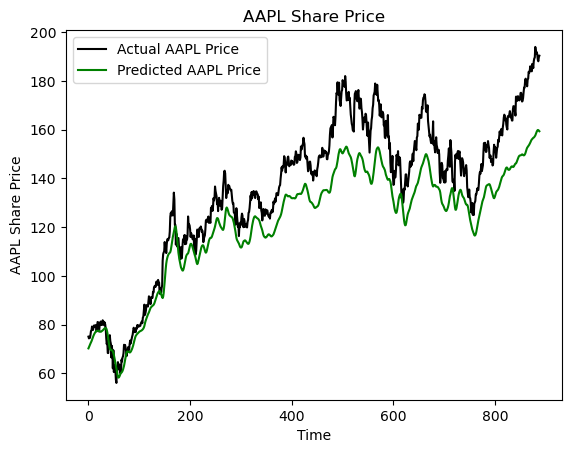

[[157.3999939 ]
 [159.27999878]
 [157.83000183]
 [158.92999268]
 [160.25      ]
 [158.27999878]
 [157.6499939 ]
 [160.77000427]
 [162.36000061]
 [164.8999939 ]
 [166.16999817]
 [165.63000488]
 [163.75999451]
 [164.66000366]
 [162.02999878]
 [160.80000305]
 [160.1000061 ]
 [165.55999756]
 [165.21000671]
 [165.22999573]
 [166.47000122]
 [167.63000488]
 [166.6499939 ]
 [165.02000427]
 [165.33000183]
 [163.77000427]
 [163.75999451]
 [168.41000366]
 [169.67999268]
 [169.58999634]
 [168.53999329]
 [167.44999695]
 [165.78999329]
 [173.57000732]
 [173.5       ]
 [171.77000427]
 [173.55999756]
 [173.75      ]
 [172.57000732]
 [172.07000732]
 [172.07000732]
 [172.69000244]
 [175.05000305]
 [175.16000366]
 [174.19999695]
 [171.55999756]
 [171.83999634]
 [172.99000549]
 [175.42999268]
 [177.30000305]
 [177.25      ]
 [180.08999634]
 [180.94999695]
 [179.58000183]
 [179.21000671]
 [177.82000732]
 [180.57000732]
 [180.96000671]
 [183.78999329]
 [183.30999756]
 [183.94999695]
 [186.00999451]
 [184.91

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Load Data
company = 'AAPL'

start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)

data = yf.download(company, start=start, end=end)

# Prepare Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']].values)

prediction_days = 80

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

'''Test the model accuracy on existing data'''

# Load Test Data
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

test_data = yf.download(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# Make Predictions on Test Data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Plot the test predictions
plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.savefig("lstm.jpg")
plt.show()

# Predict Next Day
real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
print(scaler.inverse_transform(real_data[-1]))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")


In [25]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(actual_prices, predicted_prices)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 118.50084753265114


[*********************100%***********************]  1 of 1 completed
Epoch 1/50
61/61 [==============================] - 39s 401ms/step - loss: 0.0063
Epoch 2/50
61/61 [==============================] - 25s 406ms/step - loss: 0.0016
Epoch 3/50
61/61 [==============================] - 24s 399ms/step - loss: 0.0015
Epoch 4/50
61/61 [==============================] - 26s 427ms/step - loss: 0.0012
Epoch 5/50
61/61 [==============================] - 25s 403ms/step - loss: 0.0014
Epoch 6/50
61/61 [==============================] - 25s 417ms/step - loss: 0.0013
Epoch 7/50
61/61 [==============================] - 25s 418ms/step - loss: 0.0014
Epoch 8/50
61/61 [==============================] - 24s 399ms/step - loss: 0.0012
Epoch 9/50
61/61 [==============================] - 24s 391ms/step - loss: 0.0012
Epoch 10/50
61/61 [==============================] - 25s 413ms/step - loss: 0.0010
Epoch 11/50
61/61 [==============================] - 25s 414ms/step - loss: 9.6063e-04
Epoch 12/50
61/61 [====

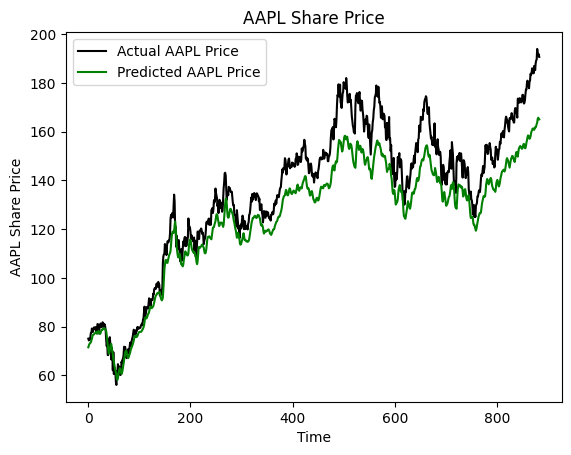

1/1 [==============================] - 0s 98ms/step
Next Day Prediction: [[164.53032]]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load Data
company = 'AAPL'

start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)

data = yf.download(company, start=start, end=end)

# Prepare Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']].values)

prediction_days = 80

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the Model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, batch_size=32)

'''Test the model accuracy on existing data'''

# Load Test Data
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

test_data = yf.download(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# Make Predictions on Test Data
x_test = np.array([model_inputs[i - prediction_days:i, 0] for i in range(prediction_days, len(model_inputs))])
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Evaluation Metrics
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Percentage Error: {mape}%")

# Plot the test predictions
plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.savefig("lstm.jpg")
plt.show()

# Predict Next Day
real_data = [model_inputs[-prediction_days:].flatten()]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
next_day_prediction = model.predict(real_data)
next_day_prediction = scaler.inverse_transform(next_day_prediction)
print(f"Next Day Prediction: {next_day_prediction}")


[*********************100%***********************]  1 of 1 completed
Epoch 1/50
61/61 [==============================] - 48s 556ms/step - loss: 0.0075
Epoch 2/50
61/61 [==============================] - 34s 561ms/step - loss: 0.0012
Epoch 3/50
61/61 [==============================] - 34s 563ms/step - loss: 0.0010
Epoch 4/50
61/61 [==============================] - 34s 561ms/step - loss: 0.0010
Epoch 5/50
61/61 [==============================] - 34s 558ms/step - loss: 9.1083e-04
Epoch 6/50
61/61 [==============================] - 34s 561ms/step - loss: 0.0010
Epoch 7/50
61/61 [==============================] - 34s 562ms/step - loss: 0.0011
Epoch 8/50
61/61 [==============================] - 34s 560ms/step - loss: 9.3922e-04
Epoch 9/50
61/61 [==============================] - 34s 557ms/step - loss: 0.0010
Epoch 10/50
61/61 [==============================] - 34s 553ms/step - loss: 8.8793e-04
Epoch 11/50
61/61 [==============================] - 34s 556ms/step - loss: 8.6282e-04
Epoch 12/50

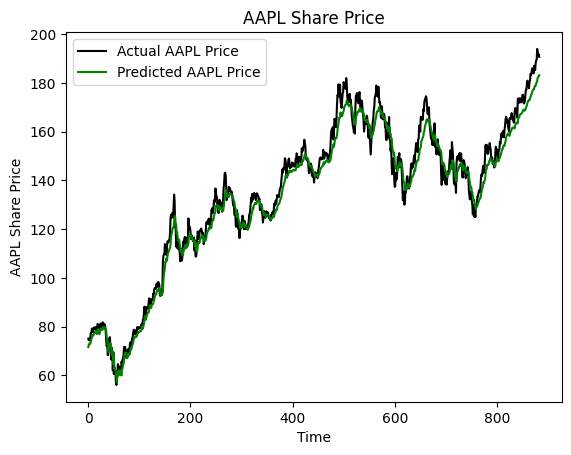

1/1 [==============================] - 0s 95ms/step
Next Day Prediction: [[183.16289]]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Load Data
company = 'AAPL'

start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)

data = yf.download(company, start=start, end=end)

# Prepare Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']].values)

prediction_days = 80

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the Model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

'''Test the model accuracy on existing data'''

# Load Test Data
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

test_data = yf.download(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# Make Predictions on Test Data
x_test = np.array([model_inputs[i - prediction_days:i, 0] for i in range(prediction_days, len(model_inputs))])
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Evaluation Metrics
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Percentage Error: {mape}%")

# Plot the test predictions
plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.savefig("gru.jpg")
plt.show()

# Predict Next Day
real_data = [model_inputs[-prediction_days:].flatten()]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
next_day_prediction = model.predict(real_data)
next_day_prediction = scaler.inverse_transform(next_day_prediction)
print(f"Next Day Prediction: {next_day_prediction}")


LSTM Performance Metrics:
Mean Squared Error (MSE): 24.107628701344918
Root Mean Squared Error (RMSE): 4.9099520060123725
Mean Absolute Percentage Error (MAPE): 29.11211689104995%

GRU Performance Metrics:
Mean Squared Error (MSE): 24.107628701344918
Root Mean Squared Error (RMSE): 4.9099520060123725
Mean Absolute Percentage Error (MAPE): 29.11211689104995%



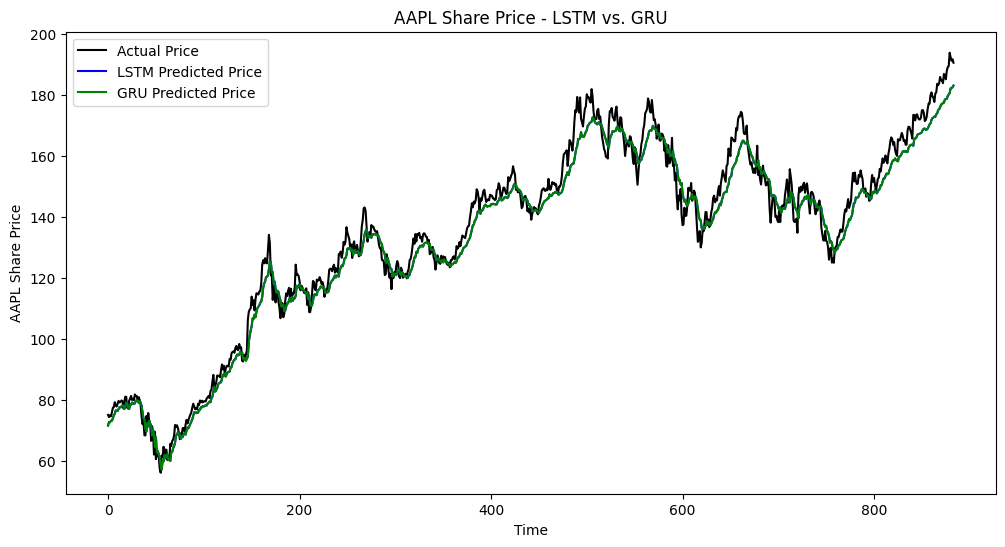

In [6]:
# Evaluation Metrics
lstm_mse = mean_squared_error(actual_prices, predicted_prices)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

gru_mse = mean_squared_error(actual_prices, predicted_prices)
gru_rmse = np.sqrt(gru_mse)
gru_mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

# Print Evaluation Metrics
print("LSTM Performance Metrics:")
print(f"Mean Squared Error (MSE): {lstm_mse}")
print(f"Root Mean Squared Error (RMSE): {lstm_rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {lstm_mape}%\n")

print("GRU Performance Metrics:")
print(f"Mean Squared Error (MSE): {gru_mse}")
print(f"Root Mean Squared Error (RMSE): {gru_rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {gru_mape}%\n")

# Plot the test predictions
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, color='black', label='Actual Price')
plt.plot(predicted_prices, color='blue', label='LSTM Predicted Price')
plt.plot(predicted_prices, color='green', label='GRU Predicted Price')
plt.title(f"{company} Share Price - LSTM vs. GRU")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.savefig("lstm_vs_gru.jpg")
plt.show()


[*********************100%***********************]  1 of 1 completed
Epoch [10/50], Loss: 9.465925541007891e-05
Epoch [20/50], Loss: 9.111707186093554e-05
Epoch [30/50], Loss: 8.588979108026251e-05
Epoch [40/50], Loss: 0.00014570918574463576
Epoch [50/50], Loss: 7.573730545118451e-05
[*********************100%***********************]  1 of 1 completed
Mean Squared Error (MSE): 76.81746154875967
Root Mean Squared Error (RMSE): 8.764557122225838
Mean Absolute Percentage Error (MAPE): 27.334648836097543%


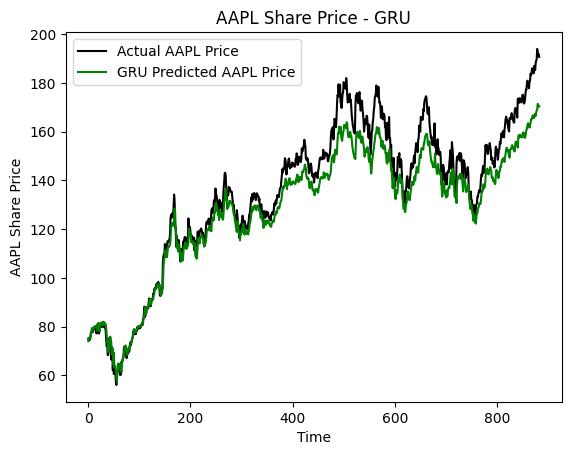

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as dt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take the last output sequence
        return out

# Load Data
company = 'AAPL'
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)
data = yf.download(company, start=start, end=end)

# Prepare Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']].values)

prediction_days = 80

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

# Define the GRU model
input_size = x_train.size(-1)
hidden_size = 100
output_size = 1
gru_model = GRUModel(input_size, hidden_size, output_size)

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gru_model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)

# Train the GRU model
num_epochs = 50
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(x_train), batch_size):
        inputs = x_train[i:i+batch_size].to(device)
        labels = y_train[i:i+batch_size].to(device)

        optimizer.zero_grad()

        outputs = gru_model(inputs)

        loss = criterion(outputs.flatten(), labels)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Evaluate the model on the test data
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()
test_data = yf.download(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)
x_test = np.array([model_inputs[i - prediction_days:i, 0] for i in range(prediction_days, len(model_inputs))])
x_test = torch.from_numpy(x_test).float().to(device)
x_test = x_test.unsqueeze(2)  # Add an extra dimension

gru_model.eval()
with torch.no_grad():
    predicted_prices = gru_model(x_test).cpu().numpy()
predicted_prices = scaler.inverse_transform(predicted_prices)

# Calculate evaluation metrics
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Plot the test predictions
plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"GRU Predicted {company} Price")
plt.title(f"{company} Share Price - GRU")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.savefig("gru_prediction.jpg")
plt.show()


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as dt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Load Data
company = 'AAPL'
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)
data = yf.download(company, start=start, end=end)

# Prepare Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']].values)

prediction_days = 80

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers, num_heads, hidden_size, dropout):
        super(TransformerModel, self).__init__()
        self.pos_encoder = PositionalEncoding(input_size, dropout, max_len=x_train.shape[1])
        encoder_layers = nn.TransformerEncoderLayer(input_size, num_heads, hidden_size, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]  # Take the last output sequence
        x = self.fc(x)
        return x

# Define the PositionalEncoding module
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        self.register_buffer('pe', self._get_positional_encoding(max_len, d_model))

    def forward(self, x):
        x = x + self.pe[:x.size(1), :]
        return self.dropout(x)

    def _get_positional_encoding(self, max_len, d_model):
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

# Initialize the model
input_size = 4  # Adjust input_size to be divisible by num_heads
output_size = 1
num_layers = 4
num_heads = 4  # Adjust the number of heads as needed
hidden_size = 128
dropout = 0.2

transformer_model = TransformerModel(input_size, output_size, num_layers, num_heads, hidden_size, dropout)

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

# Train the Transformer model
num_epochs = 50
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(x_train), batch_size):
        inputs = x_train[i:i+batch_size].to(device)
        labels = y_train[i:i+batch_size].to(device)

        optimizer.zero_grad()

        outputs = transformer_model(inputs)

        loss = criterion(outputs.flatten(), labels)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Evaluate the model on the test data
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()
test_data = yf.download(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)
x_test = np.array([model_inputs[i - prediction_days:i, 0] for i in range(prediction_days, len(model_inputs))])
x_test = torch.from_numpy(x_test).float().to(device)

transformer_model.eval()
with torch.no_grad():
    predicted_prices = transformer_model(x_test).cpu().numpy()
predicted_prices = scaler.inverse_transform(predicted_prices)

# Calculate evaluation metrics
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Plot the test predictions
plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Transformer Predicted {company} Price")
plt.title(f"{company} Share Price - Transformer")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed
Epoch [10/50], Loss: 0.354412317276001
Epoch [20/50], Loss: 0.13094733655452728
Epoch [30/50], Loss: 0.08930850774049759
Epoch [40/50], Loss: 0.06476093083620071
Epoch [50/50], Loss: 0.06027328968048096
[*********************100%***********************]  1 of 1 completed


RuntimeError: The size of tensor a (80) must match the size of tensor b (4) at non-singleton dimension 2